# MOLI for Drug Response Prediction w/ Optuna

The following code is the interpretation of the original MOLI for drug reponse prediction analysis as presented in 
[MOLI: multi-omics late integration with deep neural networks for drug response prediction][1] by Sharifi-Noghabi *et al.* (2019)
using the moli package provided in this repository, hyperparameter optimization using [Optuna][2], and the [PyTorch Lightning][3]
framework. 

[1]: https://doi.org/10.1093/bioinformatics/btz318
[2]: https://optuna.org/
[3]: https://lightning.ai/docs/pytorch/latest/

In [1]:
import moli
import uuid
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.optim as optim
device = torch.device('cuda')
torch.set_float32_matmul_precision('medium')

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

from sklearn.model_selection import RepeatedStratifiedKFold
from torchmetrics import AUROC
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})

Global DataLoader parameters

In [2]:
num_workers=32
pin_memory=False
persistent_workers=True

## Drug Response Data

The harmonized drug response data was downloaded from the [MOLI Zenodo repository Version 3][4].
Seven drug, training set, and training set combinations are used in the analysis

[4]: https://doi.org/10.5281/zenodo.4036592

In [3]:
zenodo_dir = './data/4036592'

In [4]:
study_sets = pd.DataFrame([
    ('GDSC', 'PDX', 'Cetuximab', 0.53),
    ('GDSC', 'PDX', 'Erlotinib', 0.63),
    ('GDSC', 'PDX', 'Gemcitabine', 0.64),
    ('GDSC', 'PDX', 'Paclitaxel', 0.74),
    ('GDSC', 'TCGA', 'Cisplatin', 0.66),
    ('GDSC', 'TCGA', 'Docetaxel', 0.58),
    ('GDSC', 'TCGA', 'Gemcitabine', 0.65)
], columns = ['training set', 'testing set', 'drug', 'Reported AUROC'])
study_sets

,training set,testing set,drug,Reported AUROC
0,GDSC,PDX,Cetuximab,0.53
1,GDSC,PDX,Erlotinib,0.63
2,GDSC,PDX,Gemcitabine,0.64
3,GDSC,PDX,Paclitaxel,0.74
4,GDSC,TCGA,Cisplatin,0.66
5,GDSC,TCGA,Docetaxel,0.58
6,GDSC,TCGA,Gemcitabine,0.65


## PyTorch Lightning

Model wrapper class definitions to use PyTorch Lightning framework

In [5]:
class LitMoliNet(pl.LightningModule):
    
    def __init__(self, model, optimizer, margin, gamma):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.criterion = moli.loss.moli_combination_loss
        self.margin = margin
        self.gamma = gamma
        self.train_auroc = AUROC(task='binary', compute_on_step=False)
        self.val_auroc = AUROC(task='binary', compute_on_step=False)
    
    def forward(self, x_e, x_m, x_c):
        return self.model(x_e, x_m, x_c)
    
    @staticmethod
    def invalid_batch(target):
        return torch.mean(target) == 0. or torch.mean(target) == 1. or len(target)<=2
            
    @staticmethod
    def invalid_pred(pred):
        return torch.any(torch.isnan(pred)).item()
    
    def training_step(self, batch, batch_idx):
        x_e, x_m, x_c, y = batch
        if self.invalid_batch(y):
            return None
        emb, y_hat = self.model(x_e, x_m, x_c)
        if self.invalid_pred(y_hat):
            return None
        loss = self.criterion(y_hat, y, emb, self.margin, self.gamma)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=False)
        # AUROC
        self.train_auroc.update(y_hat, y)
        try:
            self.log('train_auroc', self.train_auroc, on_step=False, on_epoch=True, prog_bar=True)
        except ValueError:
            pass
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_e, x_m, x_c, y = batch
        if self.invalid_batch(y):
            return None
        emb, y_hat = self.model(x_e, x_m, x_c)
        # AUROC - calculated before loss in case loss is NaN
        self.val_auroc.update(y_hat, y)
        try:
            self.log('val_auroc', self.val_auroc, on_step=False, on_epoch=True, prog_bar=True)
        except ValueError:
            pass
        # loss
        if self.invalid_pred(y_hat):
            return None
        loss = self.criterion(y_hat, y, emb, self.margin, self.gamma)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = self.optimizer
        return optimizer

## Bayesian Hyperparameter Optimization

Determine the optimal set of hyperparameters from the search-space described in Table S2. Instead of 
setting epoch as a hyperparameter, early stopping was conducted on the validation set and the 
largest number of epochs will be using for the final model.

### Hyperparameter selection utility functions

Utility functions for selecting hyperparameters during optimization and generating 
the final model. `define_*` functions select a new set of hyperparamters visa Optuna's
suggest methods and `get_*` functions return objects based on a provided set of hyperparameters.

In [6]:
def define_model(trial, exp_size, mut_size, cna_size):
    # Number of nodes
    exp_hl = trial.suggest_int("exp_hl", 16, 2048, step=16)
    mut_hl = trial.suggest_int("mut_hl", 16, 2048, step=16)
    cna_hl = trial.suggest_int("cna_hl", 16, 2048, step=16)
    # Dropout rate
    exp_dr = trial.suggest_float("exp_dr", 0.3, 0.8, step=0.1)
    mut_dr = trial.suggest_float("mut_dr", 0.3, 0.8, step=0.1)
    cna_dr = trial.suggest_float("cna_dr", 0.3, 0.8, step=0.1)
    cls_dr = trial.suggest_float("cls_dr", 0.3, 0.8, step=0.1)
    
    return get_model(exp_size, exp_hl, exp_dr, mut_size, mut_hl, mut_dr, 
                     cna_size, cna_hl, cna_dr, cls_dr)

def get_model(exp_size, exp_hl, exp_dr, mut_size, mut_hl, mut_dr,
              cna_size, cna_hl, cna_dr, cls_dr):
    model = moli.nn.MoliNet(exp_size, exp_hl, exp_dr, 
                            mut_size, mut_hl, mut_dr,
                            cna_size, cna_hl, cna_dr,
                            cls_dr)
    return model

def define_optimizer(trial, model):
    # Learning rate
    exp_lr = trial.suggest_float("exp_lr", 5e-5, 1e-1, log=True)
    mut_lr = trial.suggest_float("mut_lr", 5e-5, 1e-1, log=True)
    cna_lr = trial.suggest_float("cna_lr", 5e-5, 1e-1, log=True)
    cls_lr = trial.suggest_float("cls_lr", 5e-5, 1e-1, log=True)
    # Weight decay 
    cls_wd = trial.suggest_float("cls_wd", 1e-4, 1e-1, log=True)
    
    return get_optimizer(model, exp_lr, mut_lr, cna_lr, cls_lr, cls_wd)

def get_optimizer(model, exp_lr, mut_lr, cna_lr, cls_lr, cls_wd):
    optimizer = moli.optim.MoliAdagrad(model, exp_lr, mut_lr, cna_lr, 
                                       cls_lr, cls_wd)
    return optimizer


### Optuna Objective Function

Runs a 5-Fold cross validation with 2 repeats of a PyTorch Lightning trainer. The reported metric for optimimzation 
is the AUROC of the validation set.

In [7]:
def objective_ds(trial, ds):
    
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=74656)
    stdscaler = StandardScaler()
    
    logs = {
        'train_auroc': [],
        'val_auroc': [],
        'stopped_epoch': [],
        'logger_version': []
    }
    
    for fidx, (train_idx, valid_idx) in enumerate(skf.split(ds['train']['expression'], ds['train']['response'])):
        # Training set
        train_exp = stdscaler.fit_transform(ds['train']['expression'][train_idx, :])
        train_exp = torch.FloatTensor(train_exp)
        train_mut = torch.FloatTensor(ds['train']['mutation'][train_idx, :])
        train_cna = torch.FloatTensor(ds['train']['cna'][train_idx, :])
        train_y = torch.FloatTensor(ds['train']['response'][train_idx])
        # Validation set
        valid_exp = stdscaler.transform(ds['train']['expression'][valid_idx, :])
        valid_exp = torch.FloatTensor(valid_exp)
        valid_mut = torch.FloatTensor(ds['train']['mutation'][valid_idx, :])
        valid_cna = torch.FloatTensor(ds['train']['cna'][valid_idx, :])
        valid_y = torch.FloatTensor(ds['train']['response'][valid_idx])
        # Generate dataloaders
        batch_size = trial.suggest_int("batch_size", 8, 64, step=8)
        train_dataset = torch.utils.data.TensorDataset(train_exp, train_mut, train_cna, train_y)
        train_loader = moli.utils.moli_dataloader(train_dataset, batch_size=batch_size,
                                                  num_workers=num_workers, pin_memory=pin_memory, 
                                                  persistent_workers=persistent_workers)
        valid_dataset = torch.utils.data.TensorDataset(valid_exp, valid_mut, valid_cna, valid_y)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, 
                                                   num_workers=num_workers, pin_memory=pin_memory, 
                                                   persistent_workers=persistent_workers)
        # Model
        margin = trial.suggest_float("margin", 0.5, 3.5, step=0.5)
        gamma = trial.suggest_float("gamma", 0.1, 0.6, step=0.1)
        model = define_model(trial, train_exp.shape[1], train_mut.shape[1], train_cna.shape[1])
        optimizer = define_optimizer(trial, model)
        litmodel = LitMoliNet(model, optimizer, margin, gamma)
        # Training
        escb = EarlyStopping(monitor="val_loss_epoch", mode="min", check_on_train_epoch_end=False)
        trainer = pl.Trainer(
            min_epochs=5,
            max_epochs=200,
            accelerator="gpu",
            devices=1,
            callbacks=[escb],
            log_every_n_steps=1,
            val_check_interval=1.0,
            limit_val_batches=1.0,
            check_val_every_n_epoch=1,
            num_sanity_val_steps=0,
            enable_checkpointing=False,
            enable_progress_bar=False,
        )
        trainer.fit(model=litmodel, train_dataloaders=train_loader, val_dataloaders=valid_loader)
        logs['train_auroc'].append(trainer.callback_metrics["train_auroc"].item())
        logs['val_auroc'].append(trainer.callback_metrics["val_auroc"].item())
        logs['stopped_epoch'].append(trainer.current_epoch)
        logs['logger_version'].append(trainer.logger.version)
    trial.set_user_attr("train_auroc", logs['train_auroc'])
    trial.set_user_attr("val_auroc", logs['val_auroc'])
    trial.set_user_attr("stopped_epoch", logs['stopped_epoch'])
    trial.set_user_attr("logger_version", logs['logger_version'])
    return np.mean(logs['val_auroc'])
        
        

### Run Optuna

Run 50 optimization trials for each dataset.

In [8]:
%%capture output

n_trials = 50
run_uuid = str(uuid.uuid4())
storage_name = "sqlite:///saved_studies/moli_optuna.db"

for study_set in study_sets.to_dict('records'):
    ds = moli.utils.get_dataset(study_set['drug'], study_set['training set'], study_set['testing set'], zenodo_dir)
    study_name = f"{study_set['drug']}:{study_set['training set']}:{study_set['testing set']}:{run_uuid}"
    study = optuna.create_study(
        direction="maximize",
        study_name = study_name,
        storage = storage_name)
    func = lambda trial: objective_ds(trial, ds)
    study.optimize(func, n_trials=n_trials)


[I 2023-04-14 04:39:48,436] A new study created in RDB with name: Cetuximab:GDSC:PDX:dad924c6-225a-49e9-b34c-faed9b60fd78
[I 2023-04-14 04:41:29,251] Trial 0 finished with value: 0.6903953433036805 and parameters: {'batch_size': 32, 'margin': 3.0, 'gamma': 0.5, 'exp_hl': 1280, 'mut_hl': 1520, 'cna_hl': 1824, 'exp_dr': 0.7, 'mut_dr': 0.6000000000000001, 'cna_dr': 0.4, 'cls_dr': 0.3, 'exp_lr': 0.0002758546820644258, 'mut_lr': 6.778386676552719e-05, 'cna_lr': 0.0005815069703534876, 'cls_lr': 0.08251448687996657, 'cls_wd': 0.00017834108192771916}. Best is trial 0 with value: 0.6903953433036805.
[I 2023-04-14 04:44:31,755] Trial 1 finished with value: 0.6853617310523987 and parameters: {'batch_size': 16, 'margin': 1.0, 'gamma': 0.4, 'exp_hl': 1568, 'mut_hl': 1264, 'cna_hl': 2016, 'exp_dr': 0.3, 'mut_dr': 0.6000000000000001, 'cna_dr': 0.8, 'cls_dr': 0.6000000000000001, 'exp_lr': 0.0013915484860086023, 'mut_lr': 0.0023083038392502104, 'cna_lr': 0.0001311825145376791, 'cls_lr': 0.0017364778158

### Visualize Results
Plot results of Optuna optimization. Green dots represent the AUROC of the cross-validation folds, red dots
are the average AUROC for that trial, and the grey bar is the standard deviation of the average AUROC
across 5 subsequent trials.

In [9]:
def plot_trials(study):
    tr_df = study.trials_dataframe().rename(columns={'number': 'Trial', 'user_attrs_val_auroc': 'Val. AUROC'})[['Trial', 'Val. AUROC']].explode('Val. AUROC')
    tr_avg_df = tr_df.groupby('Trial').mean().sort_values('Trial').reset_index()
    sns.set(rc={'figure.figsize':(12, 2)})
    col = sns.color_palette('hls', 5)
    sns.scatterplot(tr_df, x='Trial', y='Val. AUROC', marker='.', color = col[1])
    sns.scatterplot(tr_avg_df, x='Trial', y='Val. AUROC', color = col[0])
    tr_df_bin = tr_avg_df.assign(trial_bin = tr_avg_df.index//5 * 5 + 2.5)
    sns.lineplot(data=tr_df_bin, x="trial_bin", y="Val. AUROC", marker='', linestyle='', errorbar=('sd'))

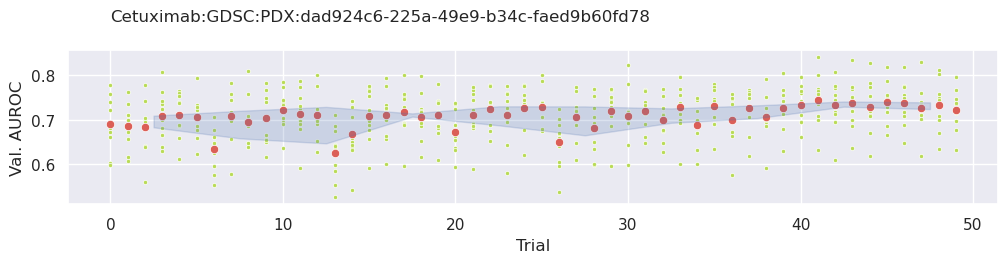

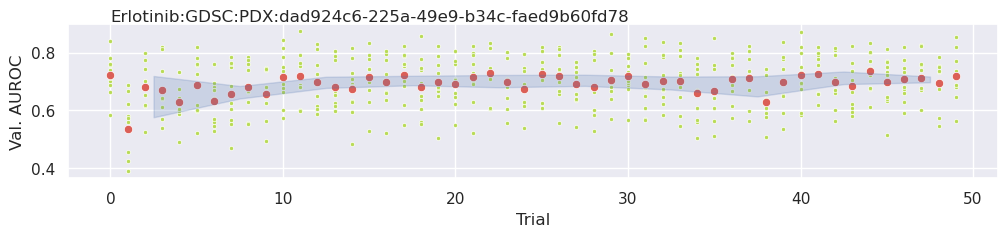

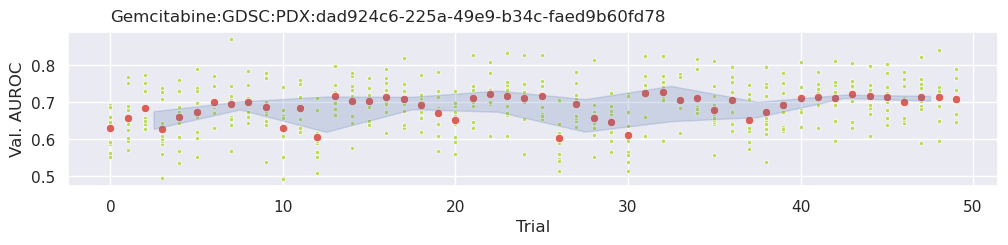

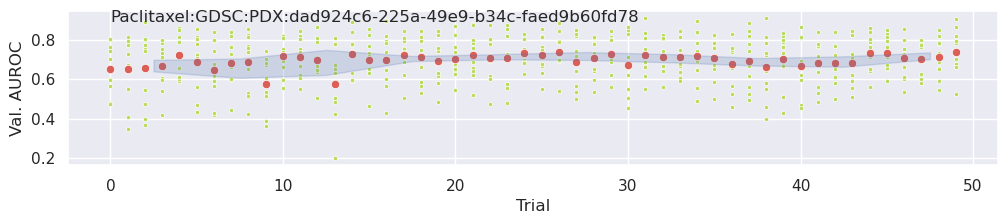

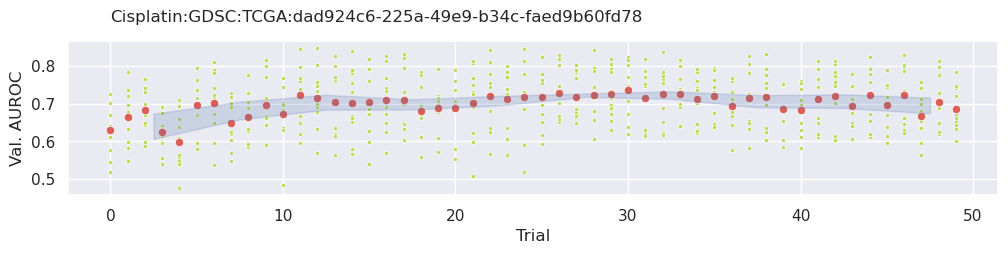

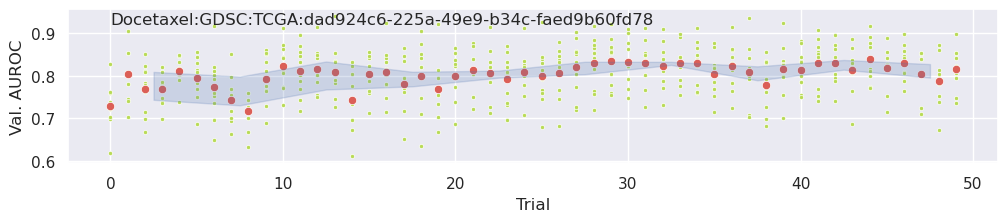

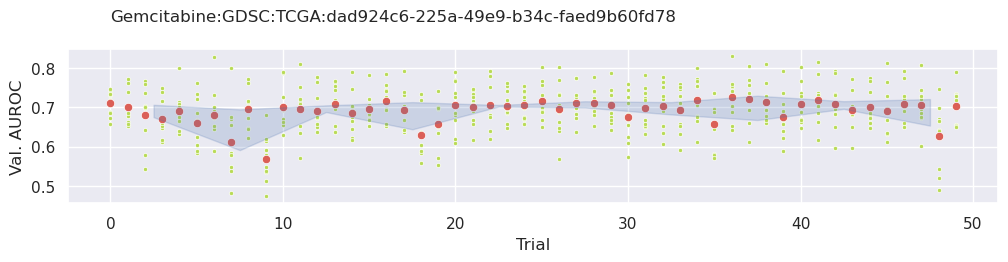

In [10]:
studies = [i.study_name for i in optuna.study.get_all_study_summaries(storage_name) if run_uuid in i.study_name]
for study_name in studies:
    study = optuna.load_study(study_name=study_name, storage=storage_name)
    plot_trials(study)
    plt.text(0, 0.95, study.study_name, horizontalalignment='left', verticalalignment='top')
    plt.show()

## Final Model and Test Set

In [11]:
%%capture output

results = []
replicates = 50
stdscaler = StandardScaler()

for study_set in study_sets.to_dict('records'):
    ds = moli.utils.get_dataset(study_set['drug'], study_set['training set'], study_set['testing set'], zenodo_dir)
    study_name = f"{study_set['drug']}:{study_set['training set']}:{study_set['testing set']}:{run_uuid}"
    study = optuna.load_study(study_name=study_name, storage=storage_name)
    hp = study.best_trial.params
    hp['epochs'] = int(np.amax(study.best_trial.user_attrs['stopped_epoch']))
    # Training set
    train_exp = stdscaler.fit_transform(ds['train']['expression'])
    train_exp = torch.FloatTensor(train_exp)
    train_mut = torch.FloatTensor(ds['train']['mutation'])
    train_cna = torch.FloatTensor(ds['train']['cna'])
    train_y = torch.FloatTensor(ds['train']['response'])
    # Test set
    test_exp = stdscaler.transform(ds['test']['expression'])
    test_exp = torch.FloatTensor(test_exp)
    test_mut = torch.FloatTensor(ds['test']['mutation'])
    test_cna = torch.FloatTensor(ds['test']['cna'])
    test_y = torch.FloatTensor(ds['test']['response'])
    # Generate dataloaders
    batch_size = hp["batch_size"]
    train_dataset = torch.utils.data.TensorDataset(train_exp, train_mut, train_cna, train_y)
    train_loader = moli.utils.moli_dataloader(train_dataset, batch_size=batch_size,
                                              num_workers=num_workers, pin_memory=pin_memory, 
                                              persistent_workers=persistent_workers)
    test_dataset = torch.utils.data.TensorDataset(test_exp, test_mut, test_cna, test_y)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                                              num_workers=num_workers, pin_memory=pin_memory, 
                                              persistent_workers=persistent_workers)
    for ridx in range(replicates):
        # Model
        model = get_model(train_exp.shape[1], hp['exp_hl'], hp['exp_dr'], 
                          train_mut.shape[1], hp['mut_hl'], hp['mut_dr'],
                          train_cna.shape[1], hp['cna_hl'], hp['cna_dr'], 
                          hp['cls_dr']) 
        optimizer = get_optimizer(model, 
                                  hp['exp_lr'], hp['mut_lr'], hp['cna_lr'], 
                                  hp['cls_lr'], hp['cls_wd'])
        litmodel = LitMoliNet(model, optimizer, hp['margin'], hp['gamma'])
        # Training
        trainer = pl.Trainer(
            max_epochs=hp['epochs'],
            accelerator="gpu",
            devices=1,
            log_every_n_steps=1,
            enable_checkpointing=False,
            enable_progress_bar=False,
        )
        trainer.fit(model=litmodel, train_dataloaders=train_loader)
        # Evaluation
        results.append({
            'drug': study_set['drug'], 
            'training set': study_set['training set'], 
            'testing set': study_set['testing set'],
            'ridx': ridx,
            'train_auroc': trainer.callback_metrics["train_auroc"].item(),
            'train_loss': trainer.callback_metrics["train_loss"].item()
        })
        trainer.test(model=litmodel, dataloaders=test_loader)
        results[-1].update({
            'val_auroc': trainer.callback_metrics["val_auroc"].item(),
            'val_loss': trainer.callback_metrics["val_auroc"].item()
        })
        
    

## Results

The following is a plot of the observed test AUCs resulting from networks Optuna determined hyperparameters.
The reported AUROC from the MOLI paper is displayed as a red X.

In [12]:
test_df = pd.DataFrame(results).rename(columns={'val_auroc': 'AUROC'})

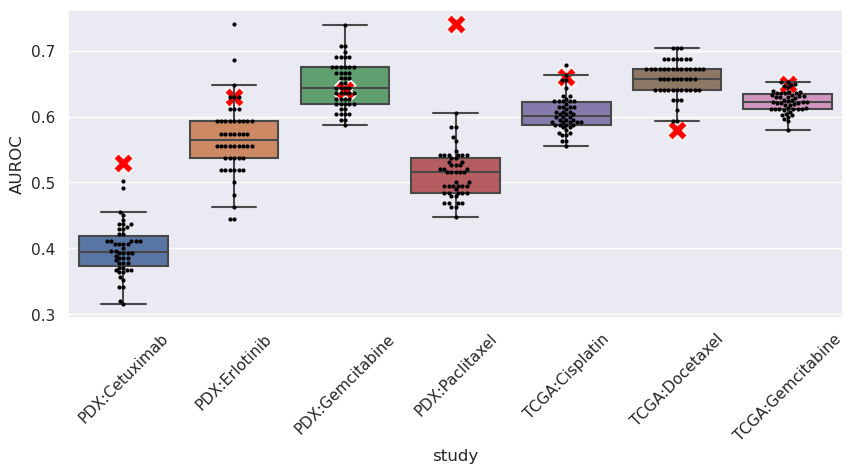

In [13]:
sns.set(rc={'figure.figsize':(10,4)})
plot_df = test_df.merge(study_sets)
plot_df['study'] = plot_df['testing set'] + ':' + plot_df['drug']
ax = sns.boxplot(y='AUROC', x='study', data=plot_df, showfliers = False)
ax.tick_params(axis='x', labelrotation=45)
ax = sns.scatterplot(y='Reported AUROC', x='study', data=plot_df, color='red', alpha=0.7, marker='X', s=200, axes=ax)
ax = sns.swarmplot(y='AUROC', x='study', data=plot_df, color='black', s=3, axes=ax)

In [14]:
(test_df
 .groupby(['drug','training set','testing set'])
 .agg(**{"min AUROC": ('AUROC', 'min'), 'mean AUROC': ('AUROC', 'mean'), 'median AUROC': ('AUROC', 'median'), 'max AUROC': ('AUROC', 'max')})
 .reset_index()
 .merge(study_sets)
 .style.highlight_max(subset = ['mean AUROC', 'Reported AUROC'],color = 'lightgreen', axis = 1)
 .format(precision=2)
)


,drug,training set,testing set,min AUROC,mean AUROC,median AUROC,max AUROC,Reported AUROC
0,Cetuximab,GDSC,PDX,0.32,0.40,0.39,0.50,0.53
1,Cisplatin,GDSC,TCGA,0.56,0.60,0.60,0.68,0.66
2,Docetaxel,GDSC,TCGA,0.59,0.66,0.66,0.70,0.58
3,Erlotinib,GDSC,PDX,0.44,0.57,0.56,0.74,0.63
4,Gemcitabine,GDSC,PDX,0.59,0.65,0.64,0.74,0.64
5,Gemcitabine,GDSC,TCGA,0.58,0.62,0.62,0.65,0.65
6,Paclitaxel,GDSC,PDX,0.45,0.51,0.52,0.61,0.74
